In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib as plt
import scvelo as scv
import cellrank as cr
import loompy
import csv

In [2]:
sc.set_figure_params(facecolor="white", figsize=(15, 15))
sc.settings.verbosity = 3

In [3]:
adata_loom_NP4 = scv.read('NP4/NP4.loom', cache=True)
adata_loom_NP4.var_names_make_unique()
adata = sc.read_10x_mtx('./NP4', gex_only = False,cache=True)
adata.var_names_make_unique()

... reading from cache file cache/NP4-NP4.h5ad
... reading from cache file cache/NP4-matrix.h5ad


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata = scv.utils.merge(adata, adata_loom_NP4)

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
adata.obs['log10GenesPerUMI'] =  np.log10(adata.obs.n_genes_by_counts) / np.log10(adata.obs.total_counts)
adata = adata[adata.obs.n_genes_by_counts < 9000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.log10GenesPerUMI > 0.8, :]
adata = adata[adata.obs.total_counts > 500, :]
adata = adata[adata.obs.pct_counts_ribo > 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=3,min_disp=0.5) # default value (may be to change)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.leiden(adata,resolution=0.2,key_added='leiden02')

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


    finished (0:00:18)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden02', the cluster labels (adata.obs, categorical) (0:00:00)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


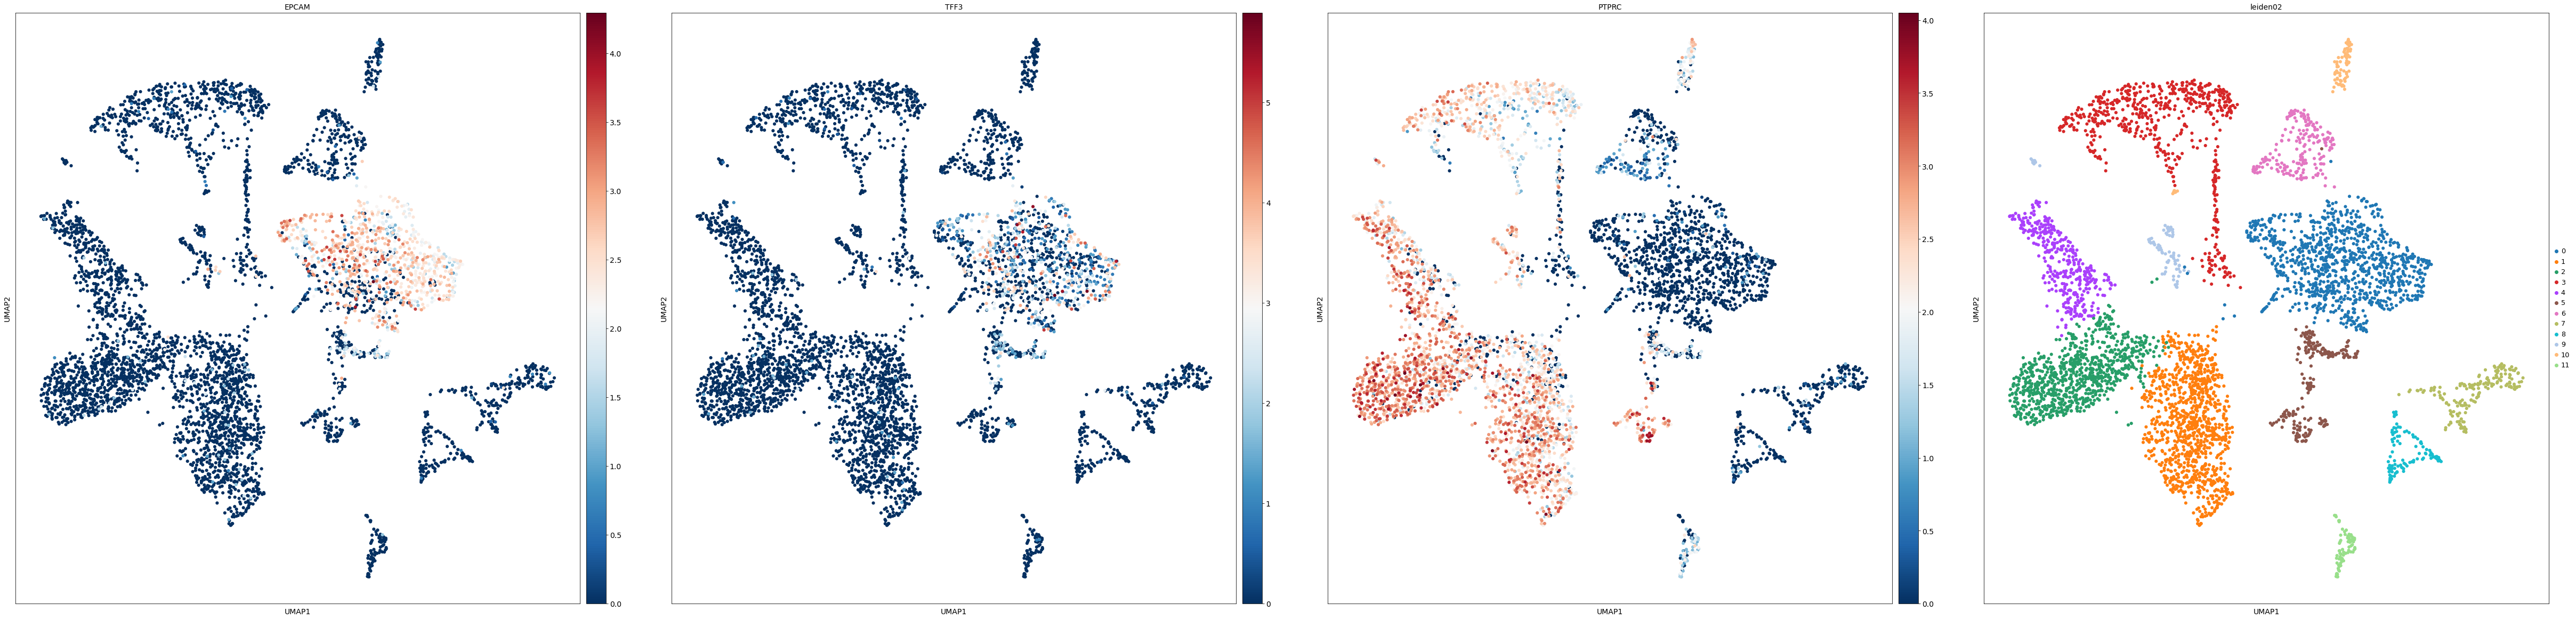

In [6]:
sc.tl.umap(adata)
sc.set_figure_params(facecolor="white", figsize=(20, 20))
sc.pl.umap(adata,color=['EPCAM','TFF3','PTPRC','leiden02'],color_map = 'RdBu_r',size=150)

In [7]:
adata_subset = adata[adata.obs['leiden02'].isin(['0'])]

In [35]:
df_genes = pd.read_csv('/home/rj/Desktop/analysis/visium/visium/signature_mak_1.csv',header=None)

list_gene = df_genes[0].tolist()

adata_gene_list =  list(adata.var['gene_ids'].keys())

gene_intersect = list(set(np.unique(np.unique(list_gene)
)) & set(adata_gene_list))

adata_subset = adata_subset[:, gene_intersect]

In [41]:
scv.pp.filter_and_normalize(adata_subset,subset_highly_variable=False,retain_genes=gene_intersect)
scv.pp.moments(adata_subset)
scv.tl.velocity_graph(adata_subset,n_jobs=8)
sc.tl.pca(adata_subset, svd_solver='arpack')
sc.pp.neighbors(adata_subset, n_neighbors=10, n_pcs=20)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 8/24 cores)


  0%|          | 0/1028 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20


/usr/local/lib/python3.8/dist-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [42]:
sc.tl.pca(adata_subset, svd_solver='arpack')
sc.pp.neighbors(adata_subset, n_neighbors=10, n_pcs=20)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [43]:
sc.tl.leiden(adata_subset,resolution=0.2,key_added='leiden03')

running Leiden clustering
    finished: found 4 clusters and added
    'leiden03', the cluster labels (adata.obs, categorical) (0:00:00)


In [44]:
sc.tl.umap(adata_subset)
sc.tl.tsne(adata_subset)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:04)


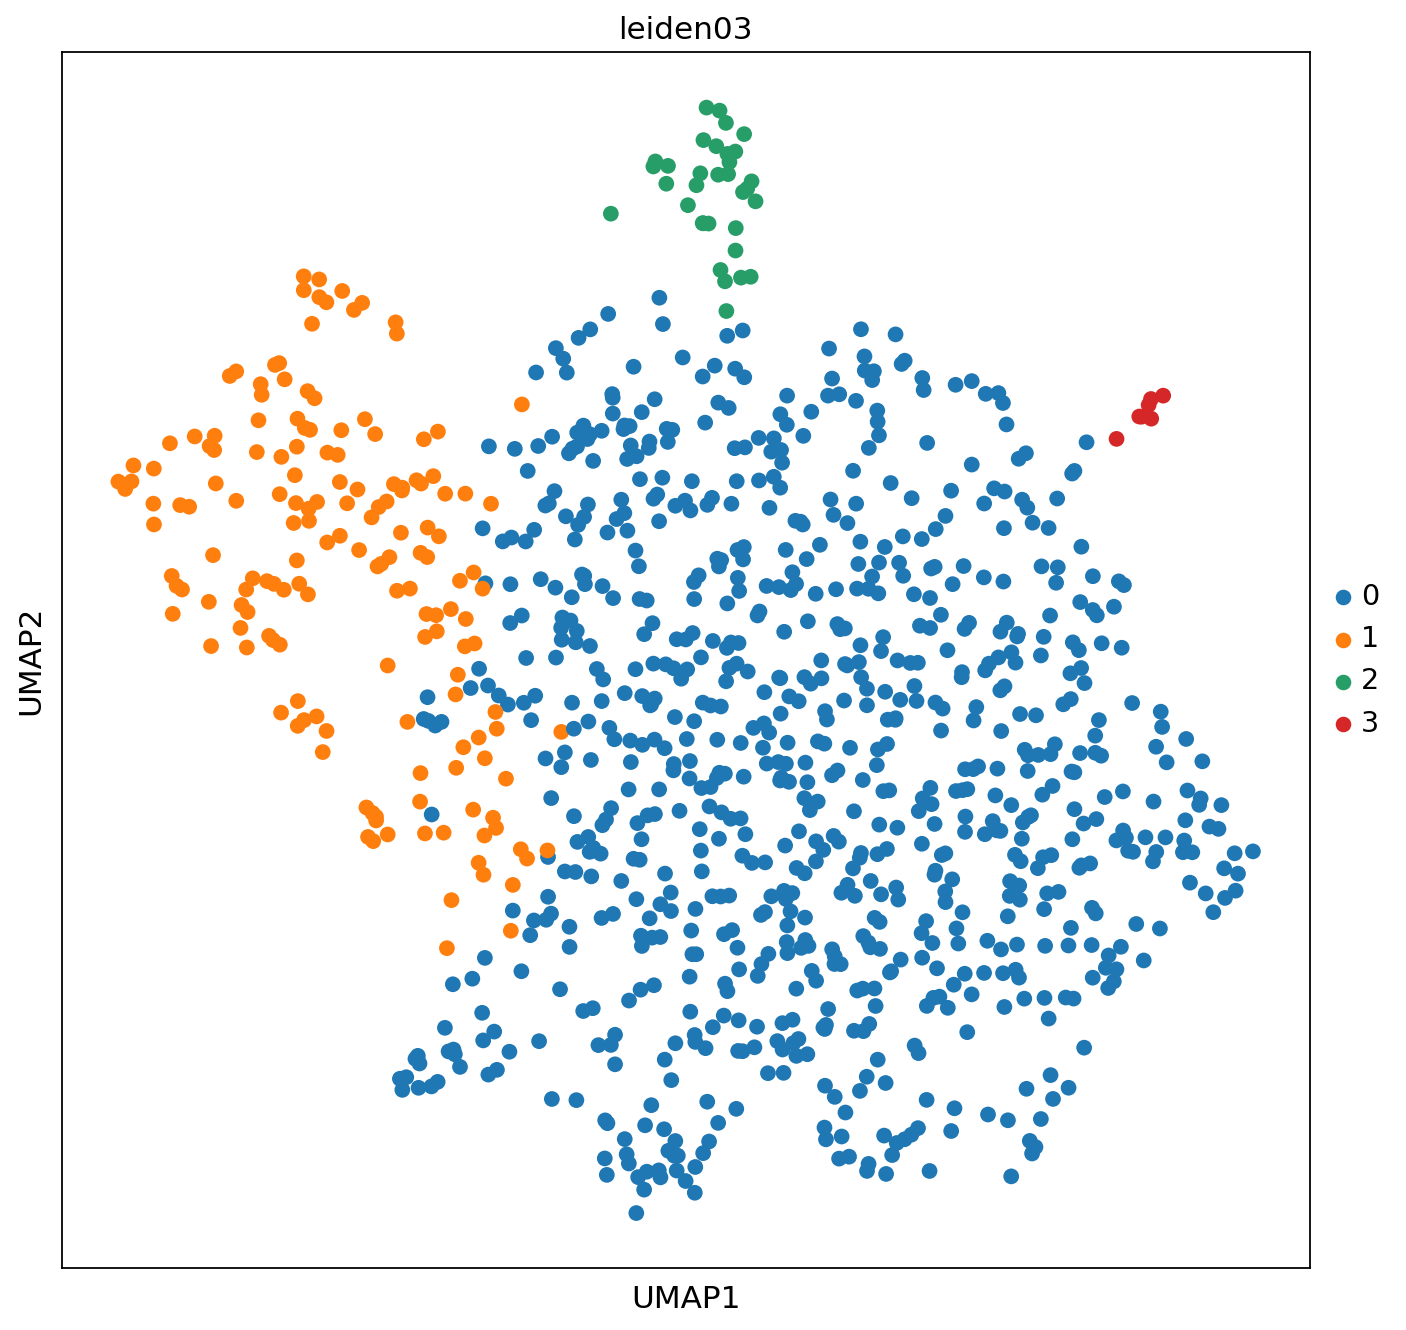

In [45]:
sc.set_figure_params(facecolor="white", figsize=(10, 10))
sc.pl.umap(adata_subset, color=['leiden03'],size=200,save='clustering_NP4.png')

In [46]:
scv.tl.velocity_graph(adata_subset)

computing velocity graph (using 1/24 cores)


  0%|          | 0/1028 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/usr/local/lib/python3.8/dist-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_umap_velocity_stream_embedding_NP4.png


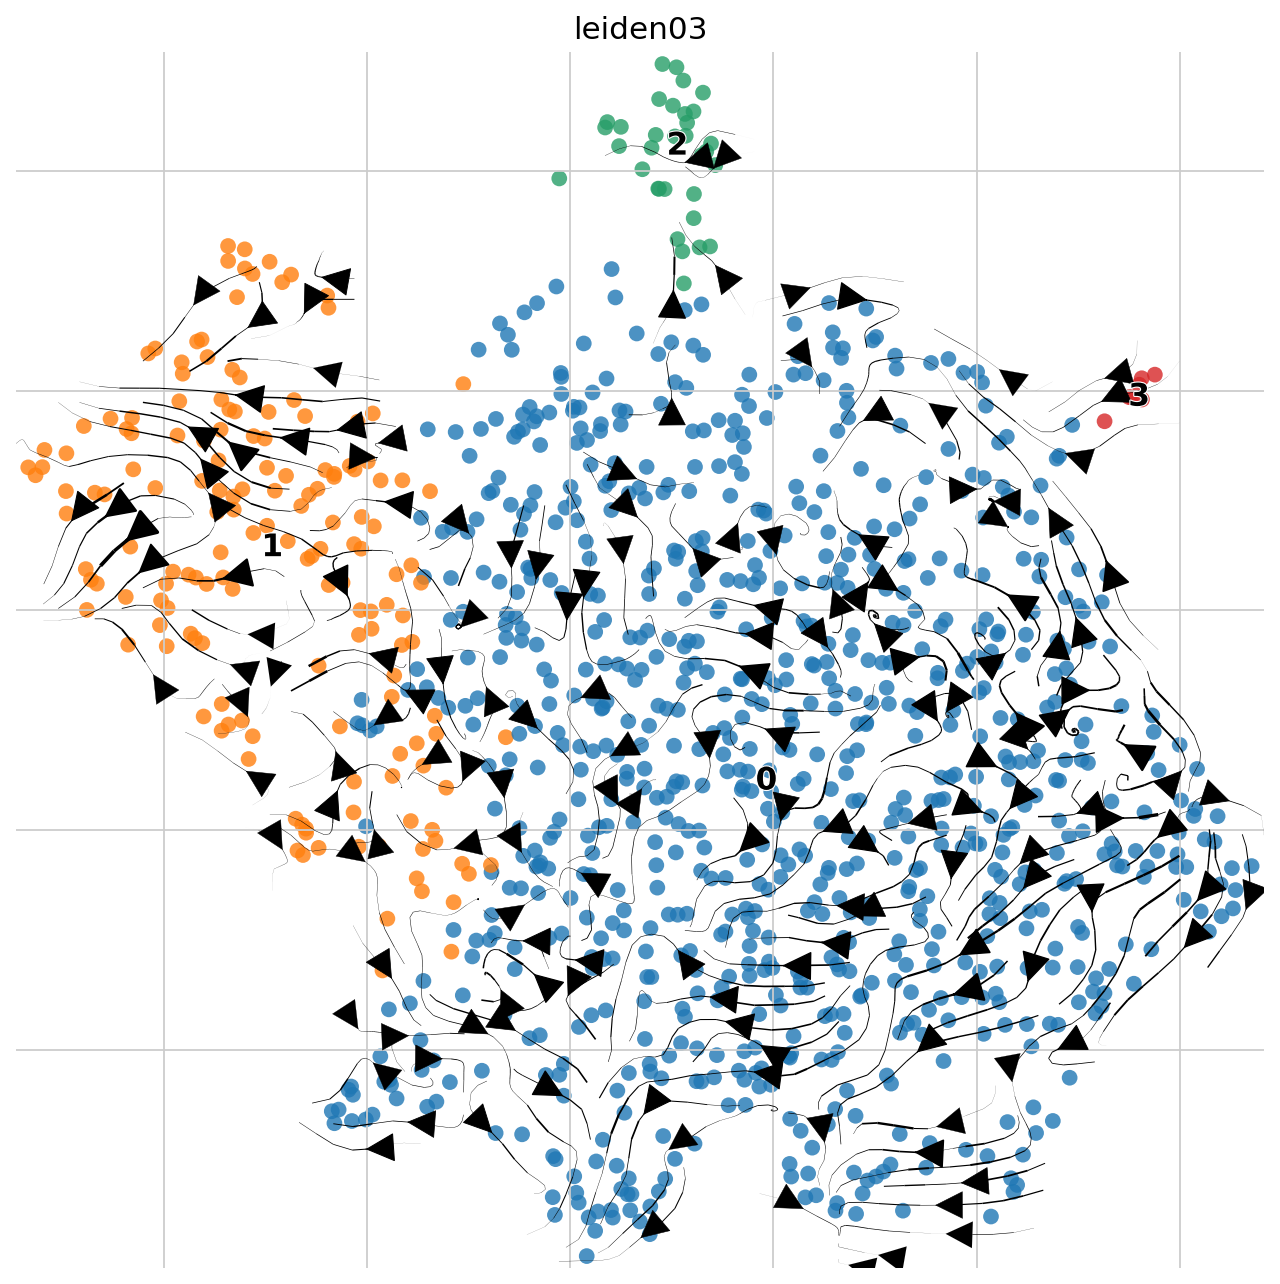

In [47]:
sc.set_figure_params(facecolor="white", figsize=(10, 10))
scv.pl.velocity_embedding_stream(adata_subset, basis='umap',color='leiden03',size=200,alpha=0.8,arrow_size=3,save='umap_velocity_stream_embedding_NP4.png')

In [48]:
scv.tl.rank_velocity_genes(adata_subset,groupby='leiden03',min_corr=0.3)

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [49]:
df  = scv.DataFrame(adata_subset.uns['rank_velocity_genes']['names'])
pd.set_option('display.max_rows', 200)
df.head(10)

0          1         2         3
0     OCLN  TNFRSF11B      CDH2     PLOD2
1     SDC4      WNT5A     MSRB3      MMP2
2      TNC        DST  SERPINE1  SERPINE1
3    FBLN1    ANGPTL2      MMP2     CXCL8
4      GEM        FN1     CADM1     PTHLH
5  COL12A1       CDH2       FN1      CDH2
6     CCN1      CADM1     CXCL8      GJA1
7   ANTXR1       FBN2     PTHLH    ANTXR1
8    PTHLH      FSTL1     PLOD2    CTHRC1
9    PLOD2      QSOX1     FSTL1       NTM

In [ ]:
scv.pl.velocity(adata_subset, ['COL23A1','COL5A2','FBLN1','COL1A2','S100P','GALNT3','KRT8','KRT19','ELF3','SLC44A4','PRSS8'],size=100,alpha=1,save='velocity_NP4.pdf') #'RIPK2','BTBD3','ESR1','GREB1','MECOM','FOS'

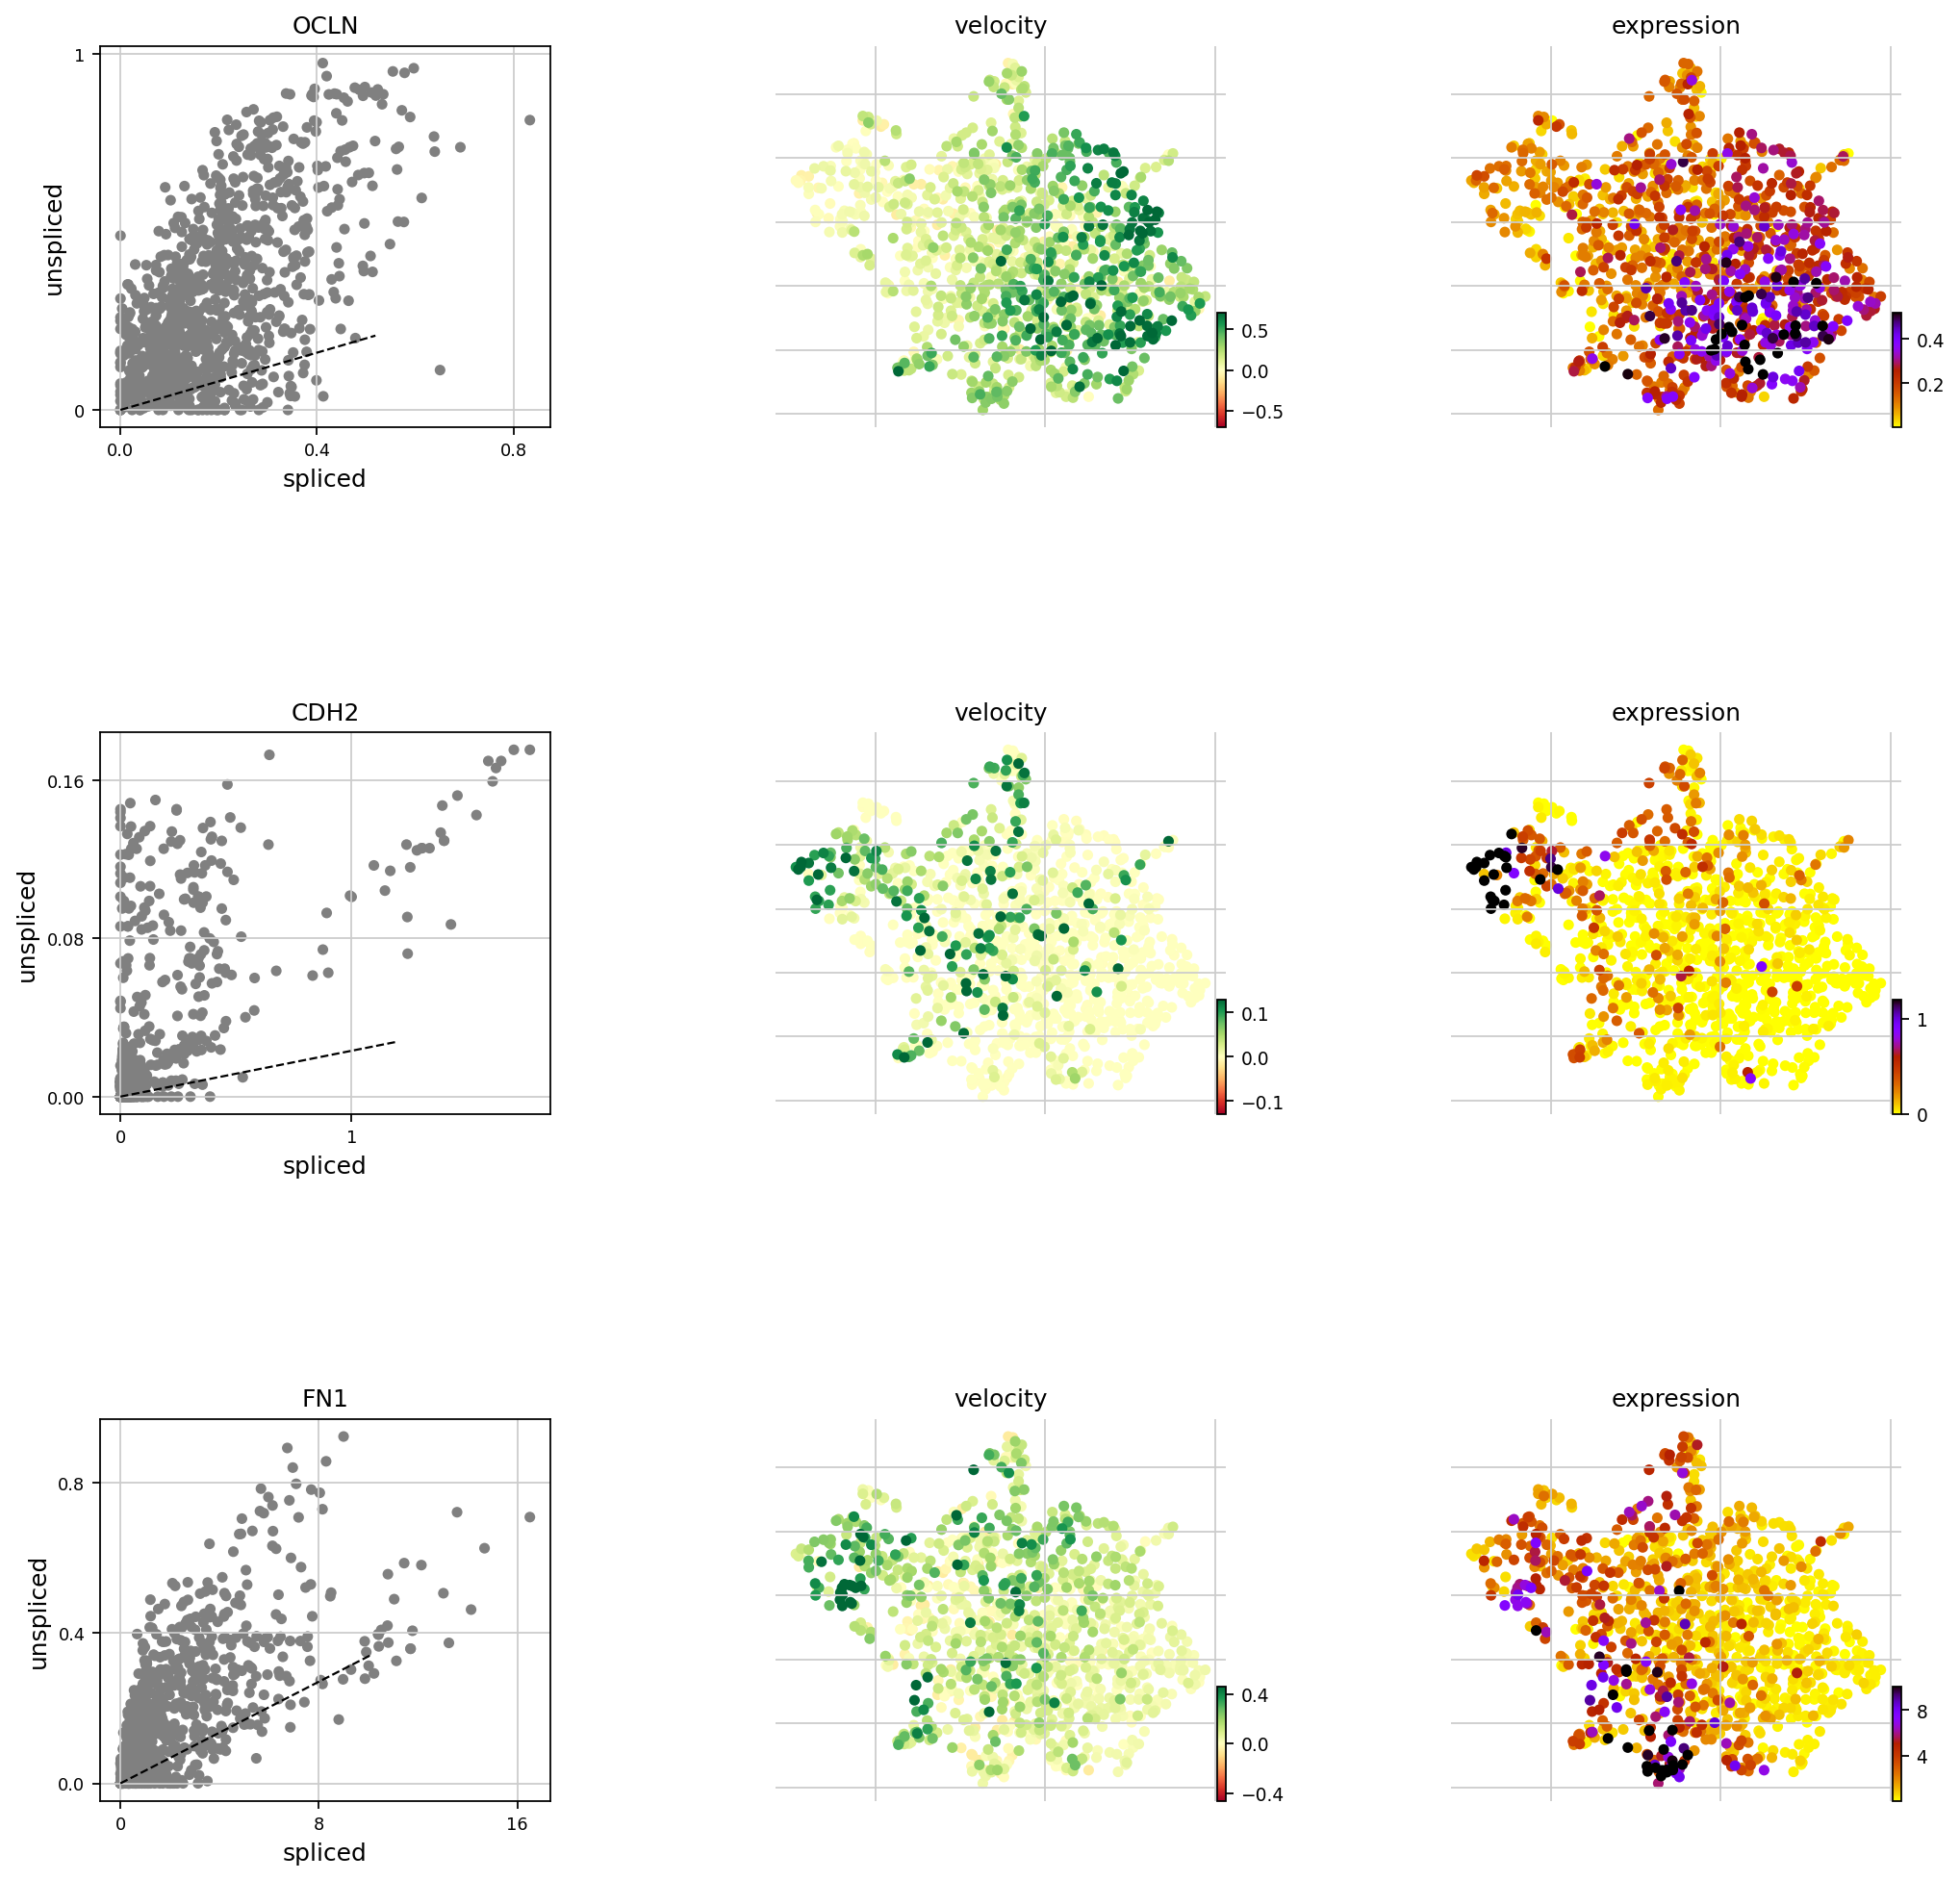

In [53]:
scv.pl.velocity(adata_subset, ['OCLN','CDH2','FN1'],size=100,alpha=1)

In [ ]:
sc.set_figure_params(facecolor="white", figsize=(10, 10))
scv.pl.velocity(adata_subset, ['COL23A1','COL5A2','FBLN1','COL1A2','NFKB1','S100P','SPINT1','GALNT3','KRT8','KRT19','ELF3','SLC44A4','PRSS8'],size=100,alpha=1) #'RIPK2','BTBD3','ESR1','GREB1','MECOM','FOS'
sc.pl.umap(adata_subset,color=['EPCAM','CLDN4','KRT19','KRT8','PRSS8'],color_map = 'RdYlGn',size=300)

In [ ]:
sc.set_figure_params(facecolor="white", figsize=(10, 10))
scv.pl.velocity(adata_subset, ['WNT5A','CDH2','SHH','WNT6','CD36','BMP7'],size=100,alpha=1)
scv.pl.velocity(adata_subset, ['BCAT1','COL12A1','FBLN1','UNC5B'],size=100,alpha=1)
sc.pl.umap(adata_subset,color=['EPCAM','CLDN4'],color_map = 'RdYlGn',size=300)